## This nb borrowed lines from fastai, OpenAI & ChatGPT

# Failed

In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel

In [2]:
import torchvision.transforms.functional as TF,torch.nn.functional as F
from miniai.imports import *
from miniai.datasets import *
from datasets import load_dataset,load_dataset_builder

In [3]:
from huggingface_hub import hf_hub_download
import json 

In [4]:
class GPUCUDAMissing(BaseException):
    pass
    
try:
    if torch.cuda.is_available():
        print('# of GPUs available = ', torch.cuda.device_count())
    else:
        raise GPUCUDAMissing
except GPUCUDAMissing:
    print("ERROR: GPU is missing")

# of GPUs available =  1


### Loading Tiny-Imagenet

In [5]:
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
dsd = load_dataset(name)

In [6]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

### Cutdown dataset

def slice_equally(vector, items_per_category, items_to_select):
    total_items = len(vector)
    idx = []
    for category_start in range(0, total_items, items_per_category):
        idx.extend(range(category_start, category_start + items_to_select))
    return idx

lbls_t = np.array(dsd['train']['label'])
idx_t = slice_equally(lbls_t, items_per_category = 500, items_to_select = 200)
#npvector[idx_t]

lbls_v = np.array(dsd['valid']['label'])
idx_v = slice_equally(lbls_v, items_per_category = 50, items_to_select = 20)
#npvector[idx_v]

In [7]:
num_of_classes_in_dsd = 2
idx_t = range(500*num_of_classes_in_dsd)
idx_v = range(50*num_of_classes_in_dsd)

In [8]:
dsd['train'] = dsd['train'].select(idx_t)

In [9]:
dsd['valid'] = dsd['valid'].select(idx_v)

In [10]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 100
    })
})

In [11]:
@inplace
def transformi(b): b[xl] = [(torch.ones([3,1,1])*(TF.to_tensor(o)-0.0)) for o in b[xl]]
    
bs = 64
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=7)
dt = dls.train
xb,yb = next(iter(dt))

### Generate captions for CLIP to use

In [12]:
# load the files
fp_json_pos2idx = hf_hub_download(repo_id=name, filename="dataset_infos.json", repo_type="dataset")
fp_idx2human = hf_hub_download(repo_id=name, filename="classes.py", repo_type="dataset")

In [13]:
f = open(fp_json_pos2idx,) 
data_pos2idx = json.load(f) 
f.close() 

In [14]:
# Repo provided a variable called 'i2d'
exec(open(fp_idx2human).read()) 
# Let's rename this variable to something suitable for this notebook
idx2human = i2d

In [15]:
pos2idx = data_pos2idx['Maysee--tiny-imagenet']['features']['label']['names']
pos2human = [idx2human[v] for k,v in enumerate(pos2idx)]
captions = ["A photo of a " + txt.split(",")[0] for txt in pos2human]

Optional: Use the cmd below to determine if VM-Container is paging while loading these models

apt update && apt-get install sysstat && pidstat -r -d --human 3

In [16]:
#show_images(xb[0:15])

### Pass img_features to SD training

In [17]:
#| export
def abar(t): return (t*math.pi/2).cos()**2
def inv_abar(x): return x.sqrt().acos()*2/math.pi

def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    ε = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return (xt, t.to(device)), ε

def collate_ddpm(b): return noisify(default_collate(b)[xl])

Info: In order to fix some CUDA multiprocessing issue which I don't understand. Please set num_workers=0 as shown in the cell below. Source: https://github.com/pytorch/pytorch/issues/40403#issuecomment-731782611

In [18]:
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=0)

In [19]:
class TinyHFDS:
    # this is specific for Hugging Face's dsd which can be very slow to index
    def __init__(self, hg_ds):
        self.ds = hg_ds
        # the 2 lines below must be done here because the execution of "ds['train']['image']" takes 18seconds
        # once it has executed, indexing it is very fast (5 milliseconds)
        self.image = hg_ds['image']
        self.label = hg_ds['label']
    def __len__(self): return self.ds.num_rows
    def __getitem__(self, i):
        #import pdb; pdb.set_trace() 
        img_3ch = torch.ones([3,1,1])*TF.to_tensor(self.image[i])
        img_3ch = img_3ch-0.5 
        #return img_3ch, self.label[i]
        return img_3ch, self.label[i]

In [20]:
def collate_ddpm(b):
    #import pdb; pdb.set_trace()    
    b = default_collate(b)
    (xt,t),eps = noisify(b[0])       # original line from Jeremy

    return (xt,t,b[1]),eps

In [21]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 100
    })
})

In [22]:
tds = TinyHFDS(dsd['train'])

In [23]:
vds = TinyHFDS(dsd['valid'])

In [24]:
#tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds), dl_ddpm(vds))

dl = dls.train

In [25]:
(xt,t,c),eps = b = next(iter(dl))

In [26]:
xt.shape, t.shape, c.shape, eps.shape

(torch.Size([64, 3, 64, 64]),
 torch.Size([64]),
 torch.Size([64]),
 torch.Size([64, 3, 64, 64]))

In [27]:
xt[0].min(),xt[0].max()

(tensor(-3.1107), tensor(3.5326))

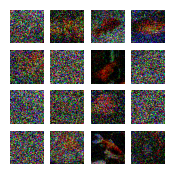

In [28]:
show_images(xt[:16].clamp(0,1), imsize=0.5)

In [29]:
c

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Build Conditional UNet from Lecture 27

# Diffusion unet

In [30]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']='1'

In [31]:
#| export
from miniai.imports import *

from einops import rearrange
from fastprogress import progress_bar

In [32]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
#if fc.defaults.cpus>8: fc.defaults.cpus=7

## Train

In [33]:
#| export
def timestep_embedding(tsteps, emb_dim, max_period= 10000):
    exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)
    emb = tsteps[:,None].float() * exponent.exp()[None,:]
    emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
    return F.pad(emb, (0,1,0,0)) if emb_dim%2==1 else emb

In [34]:
#| export
def pre_conv(ni, nf, ks=3, stride=1, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return layers

In [35]:
#| export
def upsample(nf): return nn.Sequential(nn.Upsample(scale_factor=2.), nn.Conv2d(nf, nf, 3, padding=1))

In [36]:
#| export
def lin(ni, nf, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Linear(ni, nf, bias=bias))
    return layers

In [37]:
# This version is giving poor results - use the cell below instead
class SelfAttention(nn.Module):
    def __init__(self, ni, attn_chans):
        super().__init__()
        self.attn = nn.MultiheadAttention(ni, ni//attn_chans, batch_first=True)
        self.norm = nn.BatchNorm2d(ni)

    def forward(self, x):
        n,c,h,w = x.shape
        x = self.norm(x).view(n, c, -1).transpose(1, 2)
        x = self.attn(x, x, x, need_weights=False)[0]
        return x.transpose(1,2).reshape(n,c,h,w)

In [38]:
#| export
class SelfAttention(nn.Module):
    def __init__(self, ni, attn_chans, transpose=True):
        super().__init__()
        self.nheads = ni//attn_chans
        self.scale = math.sqrt(ni/self.nheads)
        self.norm = nn.LayerNorm(ni)
        self.qkv = nn.Linear(ni, ni*3)
        self.proj = nn.Linear(ni, ni)
        self.t = transpose
    
    def forward(self, x):
        n,c,s = x.shape
        if self.t: x = x.transpose(1, 2)
        x = self.norm(x)
        x = self.qkv(x)
        x = rearrange(x, 'n s (h d) -> (n h) s d', h=self.nheads)
        q,k,v = torch.chunk(x, 3, dim=-1)
        s = (q@k.transpose(1,2))/self.scale
        x = s.softmax(dim=-1)@v
        x = rearrange(x, '(n h) s d -> n s (h d)', h=self.nheads)
        x = self.proj(x)
        if self.t: x = x.transpose(1, 2)
        return x

In [39]:
#| export
class SelfAttention2D(SelfAttention):
    def forward(self, x):
        n,c,h,w = x.shape
        return super().forward(x.view(n, c, -1)).reshape(n,c,h,w)

In [40]:
#| export
class EmbResBlock(nn.Module):
    def __init__(self, n_emb, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d, attn_chans=0):
        super().__init__()
        if nf is None: nf = ni
        self.emb_proj = nn.Linear(n_emb, nf*2)
        self.conv1 = pre_conv(ni, nf, ks, act=act, norm=norm)
        self.conv2 = pre_conv(nf, nf, ks, act=act, norm=norm)
        self.idconv = fc.noop if ni==nf else nn.Conv2d(ni, nf, 1)
        self.attn = False
        if attn_chans: self.attn = SelfAttention2D(nf, attn_chans)

    def forward(self, x, t):
        inp = x
        x = self.conv1(x)
        emb = self.emb_proj(F.silu(t))[:, :, None, None]
        scale,shift = torch.chunk(emb, 2, dim=1)
        x = x*(1+scale) + shift
        x = self.conv2(x)
        x = x + self.idconv(inp)
        if self.attn: x = x + self.attn(x)
        return x

In [41]:
class SaveModule:
    def forward(self, x, *args, **kwargs):
        self.saved = super().forward(x, *args, **kwargs)
        return self.saved

class SavedEmbResBlock(SaveModule, EmbResBlock): pass
class SavedConv2d(SaveModule, nn.Conv2d): pass

In [42]:
#| export
class DownBlock(nn.Module):
    def __init__(self, n_emb, ni, nf, add_down=True, num_layers=1, attn_chans=0):
        super().__init__()
        self.resnets = nn.ModuleList([SavedEmbResBlock(n_emb, ni if i==0 else nf, nf, attn_chans=attn_chans)
                                      for i in range(num_layers)])
        self.down = SavedConv2d(nf, nf, 3, stride=2, padding=1) if add_down else nn.Identity()

    def forward(self, x, t):
        self.saved = []
        for resnet in self.resnets: 
            x = resnet(x, t)
            self.saved.append(resnet.saved)
        x = self.down(x)
        #import pdb; pdb.set_trace()
        if isinstance(self.down, SavedConv2d): self.saved.append(self.down.saved)
        return x

In [43]:
#| export
class UpBlock(nn.Module):
    def __init__(self, n_emb, ni, prev_nf, nf, add_up=True, num_layers=2, attn_chans=0):
        super().__init__()
        self.resnets = nn.ModuleList(
            [EmbResBlock(n_emb, (prev_nf if i==0 else nf)+(ni if (i==num_layers-1) else nf), nf, attn_chans=attn_chans)
            for i in range(num_layers)])
        self.up = upsample(nf) if add_up else nn.Identity()

    def forward(self, x, t, ups):
        for resnet in self.resnets: x = resnet(torch.cat([x, ups.pop()], dim=1), t)
        return self.up(x)

## Conditional model

In [44]:
class CondUNetModel(nn.Module):
    def __init__( self, n_classes, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.n_temb = nf = nfs[0]
        n_emb = nf*4
        #self.cond_emb = nn.Sequential(lin(clip_emd_size, n_emb, norm=nn.BatchNorm1d),
        #                             lin(n_emb, n_emb))
        self.cond_emb = nn.Sequential(nn.Embedding(n_classes, n_emb))
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        self.downs = nn.ModuleList()
        for i in range(len(nfs)):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=len(nfs)-1, num_layers=num_layers))
        self.mid_block = EmbResBlock(n_emb, nfs[-1])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(len(nfs)):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=len(nfs)-1, num_layers=num_layers+1))
        self.conv_out = pre_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        #import pdb; pdb.set_trace() 
        x,t,c = inp
        temb = timestep_embedding(t, self.n_temb)
        cemb = self.cond_emb(c)
        emb = self.emb_mlp(temb) + cemb
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        x = self.mid_block(x, emb)
        for block in self.ups: x = block(x, emb, saved)
        return self.conv_out(x)

In [45]:
def init_ddpm(model):
    for o in model.downs:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

    for o in model.ups:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

In [46]:
lr = 2e-5
epochs = 20
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = CondUNetModel(n_classes=num_of_classes_in_dsd, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=2)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
1.093,0,train
1.009,0,eval
0.936,1,train
0.888,1,eval
0.620,2,train
0.518,2,eval
0.312,3,train
0.241,3,eval
0.187,4,train
0.295,4,eval


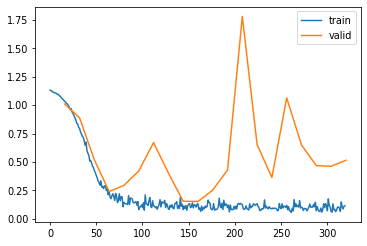

In [47]:
learn.fit(epochs)

In [65]:
#torch.save(model, 'sd_model.pkl')

In [47]:
model = torch.load('sd_model.pkl')

In [50]:
#torch.save(learn, 'sd_learn.pkl')

In [51]:
#learn = torch.load('sd_learn.pkl')

### Inference

In [48]:
#| export
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig, clamp=True):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    x_0_hat = ((x_t-(1-abar_t).sqrt()*noise) / abar_t.sqrt())
    if clamp: x_0_hat = x_0_hat.clamp(-1,1)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat,x_t

In [50]:
#sz = (256,1,32,32)

#def cond_sample(c, f, model, sz, steps, eta=1.):
with torch.no_grad():
    c = 11
    c = 0
    f = ddim_step
    # model = model
    sz = (32,3,64,64)
    steps = 100
    eta=1.
    ts = torch.linspace(1-1/steps,0,steps)
    x_t = torch.randn(sz).cuda()
    c = torch.ones((sz[0])).cuda() * c
    c = c.to(torch.int64)
    preds = []
    for i,t in enumerate(progress_bar(ts)):
        t = t[None].cuda()
        abar_t = abar(t)
        #import pdb; pdb.set_trace()
        with torch.no_grad(): noise = model((x_t, torch.ones(32).cuda()*t, c))
        abar_t1 = abar(t-1/steps) if t>=1/steps else torch.tensor(1)
        x_0_hat,x_t = f(x_t, noise, abar_t, abar_t1, 1-abar_t, 1-abar_t1, eta, 1-((i+1)/100))
        preds.append(x_0_hat.float().cpu())
    preds

In [51]:
captions[c[0]]

'A photo of a goldfish'

In [52]:
s = preds[-1]

In [53]:
(s).min(), (s).max()

(tensor(nan), tensor(nan))

/home/fastai_env/lib/python3.10/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


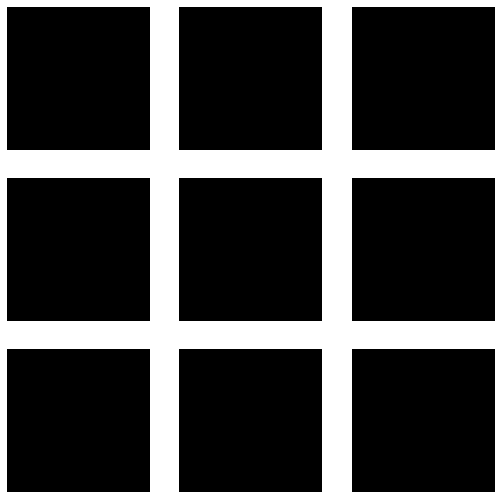

In [58]:
show_images((s[:9]/2)+0.5, imsize=3)

### Notes

In [61]:
#| export
@torch.no_grad()
def cond_sample(c, f, model, sz, steps, eta=1.):
    ts = torch.linspace(1-1/steps,0,steps)
    x_t = torch.randn(sz).cuda()
    c = x_t.new_full((sz[0],), c, dtype=torch.int32)
    preds = []
    for i,t in enumerate(progress_bar(ts)):
        t = t[None].cuda()
        abar_t = abar(t)
        noise = model((x_t, t, c))
        abar_t1 = abar(t-1/steps) if t>=1/steps else torch.tensor(1)
        x_0_hat,x_t = f(x_t, noise, abar_t, abar_t1, 1-abar_t, 1-abar_t1, eta, 1-((i+1)/100))
        preds.append(x_0_hat.float().cpu())
    return preds

In [63]:
preds = cond_sample(cid, ddim_step, model, sz, steps=100, eta=1.)
s = (preds[-1]*2)
show_images(s[:25].clamp(-1,1), imsize=2)

NameError: name 'cid' is not defined